In [29]:
from __future__ import print_function ## Force python3-like printing

try:
    from importlib import reload
except:
    pass

%matplotlib inline
# %matplotlib notebook
from matplotlib import pyplot as plt

import os
import warnings

import numpy as np
from astropy.table import Table

import pycoco as pcc

reload(pcc) ## FOR DEV
reload(pcc.kcorr) ## FOR DEV
reload(pcc.functions) ## FOR DEV
reload(pcc.classes) ## FOR DEV

warnings.resetwarnings() ## FOR DEV

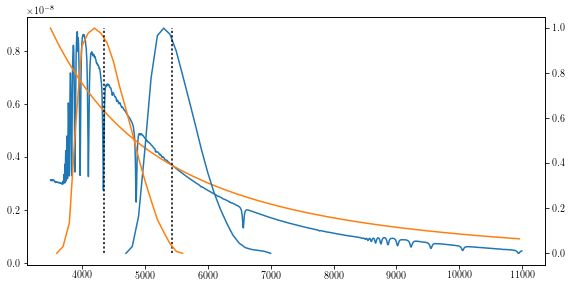

In [30]:
V = pcc.load_filter('/Users/berto/Code/CoCo/data/filters/BessellV.dat')
B = pcc.load_filter('/Users/berto/Code/CoCo/data/filters/BessellB.dat')

vega = pcc.kcorr.load_vega()
AB = pcc.kcorr.load_AB()

fig = plt.figure(figsize=[8, 4])
fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
                    right = 0.99, hspace=0, wspace = 0)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(vega.wavelength, vega.flux)
ax1.plot(AB.wavelength, AB.flux)

ax2.plot(V.wavelength, V.throughput)
ax2.plot([V.lambda_effective.value, V.lambda_effective.value], [0,1], color = hex["black"], ls = ":")
ax2.plot(B.wavelength, B.throughput)
ax2.plot([B.lambda_effective.value, B.lambda_effective.value], [0,1], color = hex["black"], ls = ":")

In [31]:
print(kcorr.calc_offset_AB_minus_Vega("BessellV"))
print(kcorr.calc_offset_AB_minus_Vega("BessellB"))
print(kcorr.calc_AB_flux("BessellB"))
print(kcorr.calc_vega_flux("BessellB"))
kcorr.calc_vega_zp("BessellB")
# kcorr.calc_vega_mag("BessellV")
kcorr.calc_vega_mag("BessellB")

0.0247907219878
0.13835977858
5.46590534646e-06
6.03956998519e-06


-0.65121903565065864

In [32]:
inpath = "/Users/berto/data/CoreCollapse/phot/rf/SN2009jf/final/SN2009jf.dat"
phot = pcc.load(inpath)

BessellB.dat
  MJD             flux                 flux_err         filter 
   d     erg / (Angstrom cm2 s) erg / (Angstrom cm2 s)         
-------- ---------------------- ---------------------- --------
55153.91      4.75113551675e-16      7.43732079049e-18 BessellB
55133.02      1.36269109536e-15      4.89364205515e-17 BessellB
55131.04      1.74581177351e-15      3.53663526862e-17 BessellB
55129.04      2.00261478415e-15      3.13484818882e-17 BessellB
55128.07      2.14979682916e-15      3.95911018261e-17 BessellB
55127.84      2.16569561895e-15      2.99129229137e-17 BessellB
55125.02      2.52346576966e-15       3.4854499581e-17 BessellB
55124.12      2.69896602725e-15      4.47342435456e-17 BessellB
55122.87      2.89199420238e-15      5.05965836512e-17 BessellB
55122.03      2.89999612764e-15      7.74400439242e-17 BessellB
     ...                    ...                    ...      ...
55101.11      2.45695622024e-16      1.35743437582e-16 BessellB
55106.13      8.78208058669

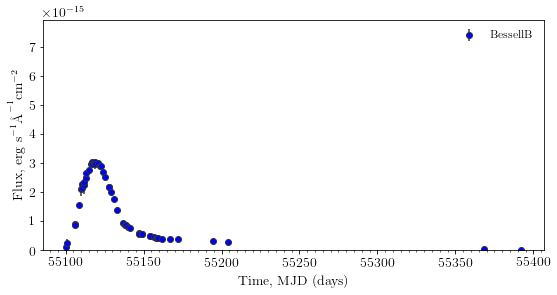

In [33]:
phot.plot("BessellB")